In [40]:
!pip install xgboost
import xgboost
import shap
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [21]:
data = 'RF_YN_Model3.csv'
df = pd.read_csv(data)
df.head()

,GWD (m),Elevation,L (km),Slope (%),PGA (g),Displ (m),Target
0,0.370809,0.909116,0.319117,5.465739,0.546270,0.000000,0
1,1.300896,1.123009,0.211770,0.905948,0.532398,0.195432,0
2,1.300896,0.847858,0.195947,0.849104,0.532398,0.217259,0
3,1.788212,2.044325,0.115795,0.451034,0.542307,0.239763,0
4,1.637517,2.003797,0.137265,0.941866,0.545784,0.377358,1


In [22]:
#define features matrix (X) and target (y)
X = df.drop(['Displ (m)', 'Target'], axis = 1)
y = df.drop(['GWD (m)', 'Elevation',  'L (km)', 'Slope (%)','PGA (g)','Target'],axis=1)

# implementing train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
y_test

,Displ (m)
4721,0.074809
4447,0.242497
831,0.451166
641,0.369019
2039,0.087944
...,...
3369,0.772191
5304,0.411917
401,0.203948
4004,0.198862


In [64]:
import numpy as np
np.mean(y_test)

In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'


Displ (m)    0.369914
dtype: float64

In [53]:
# Regression fit
model = xgboost.XGBRegressor().fit(X_train, y_train)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [54]:
# make prediction
preds = model.predict(X_test)

In [55]:
kfold = KFold(n_splits=10)
results = cross_val_score(model, X_train, y_train, cv=kfold)
y_test_pred = model.predict(X_test)

mse = mean_squared_error(y_test_pred, y_test)
print("Error: ", mse)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

Error:  0.29850189782461595


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [56]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


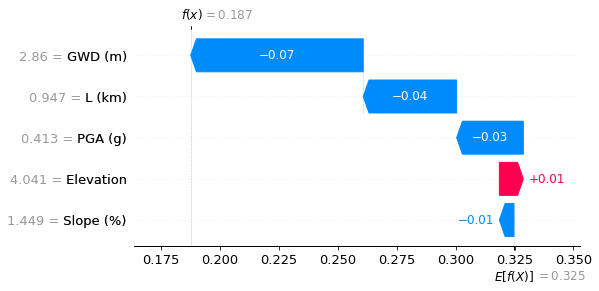

In [57]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [58]:
# visualize the first prediction's explanation with a force plot
shap.initjs()
shap.plots.force(shap_values[0])

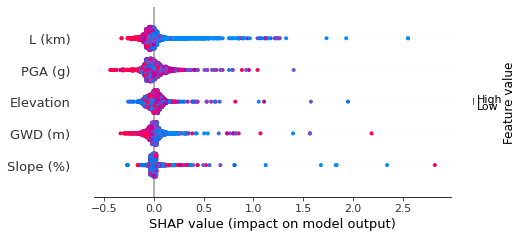

In [59]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

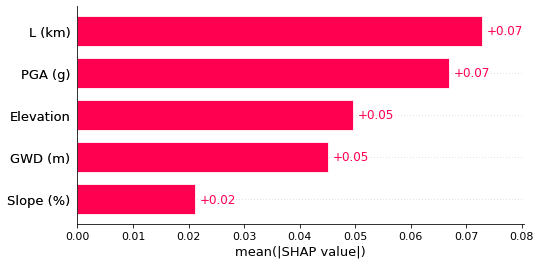

In [60]:
shap.plots.bar(shap_values)

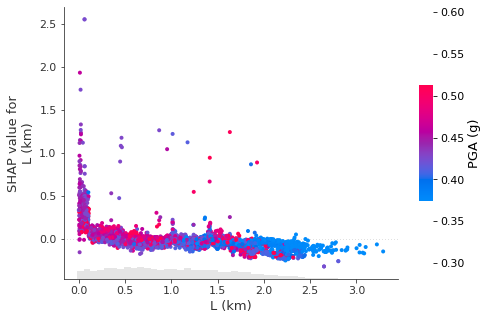

In [29]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:,"L (km)"], color=shap_values)

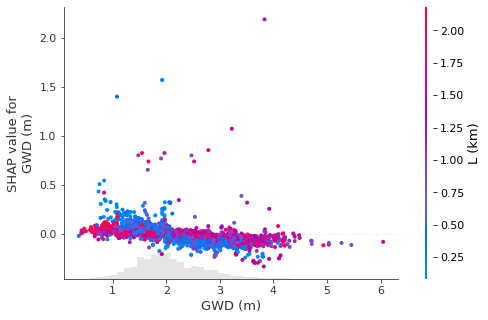

In [30]:
shap.plots.scatter(shap_values[:,"GWD (m)"], color=shap_values)

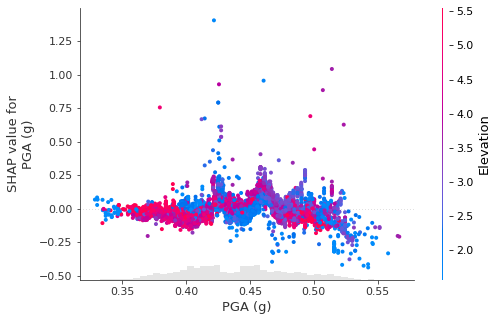

In [31]:
shap.plots.scatter(shap_values[:,"PGA (g)"], color=shap_values)

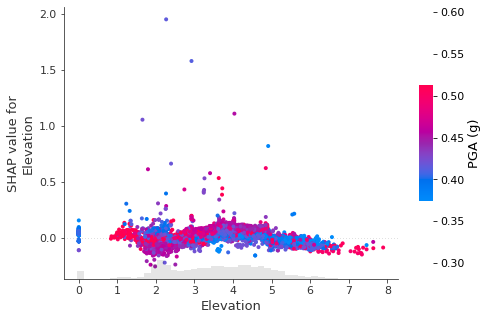

In [32]:
shap.plots.scatter(shap_values[:,"Elevation"], color=shap_values)

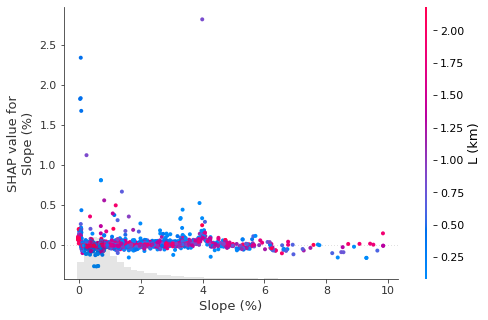

In [33]:
shap.plots.scatter(shap_values[:,"Slope (%)"], color=shap_values)

In [34]:
# visualize all the training set predictions
shap.plots.force(shap_values)

shap.plots.force is slow for many thousands of rows, try subsampling your data.
